# Teste 1 - Python

        Tentando importar e utilizar os dados do Ministério da Saúde em https://covid.saude.org.br para avaliar a situação divulgada oficialmente pelo MS; 
        A url muda diariamente... como puxar o arquivo csv automaticamente?

## Gráficos dos Dados

        Mostrar infectados e mortes confirmados diariamente
        Mostrar infectados e mortes confirmados acumulados
        Mostrar dados separados por região e por estado

## Estimativas (Regressão)
        
        Estimar próximos números (até 7 dias?) utilizando 2, 3 ou 4 (todos?) dias anteriores e regressão não linear
        
## Modelo de Contágio

        Utilizar dados adquiridos para rodar um modelo epidemiológico que utiliza valores de reprodução base e evolução da COVID-19, causada pelo vírus SARS-COV-2
  

In [22]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

url = "https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/f4c55ecfa34421c25813075ccb8f0940_Download_COVID19_20200422.csv"

In [23]:
df = pd.read_csv("arquivo_geral.csv", sep = ";")

In [24]:
df1 = df.loc[:, ['data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos']]
dfs = df.loc[:, ['regiao', 'data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos']]
df_UF = df.loc[:, ["estado", 'data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos']]

FMT = '%Y-%m-%d'

date = df['data']
regi = df['regiao']

df1['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-30", FMT)).days)
df_UF['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-30", FMT)).days)
dfs['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-30", FMT)).days)

In [25]:
df1 = df1.groupby("data").sum()

# total of days since 2020-01-30 - x
x = list(df1.index)

# total cases - y


# new cases - y

# total deaths - y
y_d = list(df1.iloc[:, 2])

# new deaths - y
y_dn = list(df1.iloc[:, 3])


In [26]:
def exponential_model (x, a, b, c) :
    return a * np.exp (b * (x - c))

#curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)[source]

def exp_param (R, X) :
    np.random.seed(19)
    a = np.exp(X[2] * (((np.log(R[2]))/X[2]) - ((np.log(R[1]) - np.log(R[0]))/(X[1] - X[0]))))
    b = (np.log(R[2])/X[2]) - (1/X[2])*(((np.log(R[0])/X[0]) - (np.log(R[1])/X[1]))/((X[0])**(-1) - (X[1])**(-1)))
    return [a, b]

In [27]:
# total cases
y = list(df1.iloc[:, 0])

exp_p = exp_param([y[-1], y[-2], y[-4]], [x[-1], x[-2], x[-4]])
exponential_fit = curve_fit(exponential_model, x, y, p0 = [exp_p[0], exp_p[1], 1], bounds = (0, df.index.size))
exponential_sol = int(fsolve(lambda x : exponential_model(x, exponential_fit[0][0], 
                                                          exponential_fit[0][1], 
                                                          exponential_fit[0][2]) - int(exponential_fit[0][2]), exponential_fit[0][1]))
exponential_errors = [np.sqrt(exponential_fit[1][i][i]) for i in [0, 1, 2]]
exponential_errors

[97230876.14017801, 0.001785822223850624, 6110693.894099958]

In [28]:
# new cases
y = list(df1.iloc[:, 1])

new_exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df.index.size))
new_exponential_sol = int(fsolve(lambda x : exponential_model(x, new_exponential_fit[0][0],
                                                              new_exponential_fit[0][1], 
                                                              new_exponential_fit[0][2]) - int(new_exponential_fit[0][2]), new_exponential_fit[0][1]))
new_exponential_errors = [np.sqrt(new_exponential_fit[1][i][i]) for i in [0, 1, 2]]
new_exponential_errors

[1530656224.4226093, 0.004349918590865921, 102114943.04232866]

In [29]:
# total deaths
y = list(df1.iloc[:, 2])

death_exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df.index.size))
death_exponential_sol = int(fsolve(lambda x : exponential_model(x, death_exponential_fit[0][0],
                                                                death_exponential_fit[0][1], 
                                                                death_exponential_fit[0][2]) - int(death_exponential_fit[0][2]), death_exponential_fit[0][1]))
death_exponential_errors = [np.sqrt(death_exponential_fit[1][i][i]) for i in [0, 1, 2]]
death_exponential_errors

[199117141.26691103, 0.0024463120351320184, 15180095.232556721]

In [30]:
# new deaths
y = list(df1.iloc[:, 3])

new_death_exponential_fit = curve_fit(exponential_model, x, y_dn, p0 = [1, 1, 1], bounds = (0, df.index.size))
new_death_exponential_sol = int(fsolve(lambda x : exponential_model(x, new_death_exponential_fit[0][0], 
                                                                    new_death_exponential_fit[0][1], 
                                                                    new_death_exponential_fit[0][2]) - int(new_death_exponential_fit[0][2]), new_death_exponential_fit[0][1]))
new_death_exponential_errors = [np.sqrt(new_death_exponential_fit[1][i][i]) for i in [0, 1, 2]]
new_death_exponential_errors

[790935020.9248313, 0.0057824667502428505, 140614532.24944744]

## logistic model

a refers to the infection speed
b is the day with the maximum infections occurred
c is the total number of recorded infected people at the infection’s end

velocidade da infecção: 2

dia de máximo de infecções: daqui a 2 semanas
dia de máximo de mortes: daqui a 4 semanas

população do Brasil: 209.500.000
população máxima infectada: 60%
população máxima infectada num dia: 2%
população máxima morta: 0.6%
população máxima morta num dia: 0.02%

In [31]:
# logistic model of the evolution of the contamination in Brazil

def logistic_model (x, a, b, c) :
    return c / (1 + np.exp ( - (x - b) / a))

# curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)[source]

a0 = 2

b0 = df1.index.size + 14
b1 = b0 + 14

pBrasil = 209500000
c0 = 0.6 * pBrasil
c1 = 0.02 * pBrasil
c2 = 0.01 * c0
c3 = 0.01 * c1

In [32]:
# total cases
y = list(df1.iloc[:, 0])

logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b0, c0])
logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1],
                                                    logistic_fit[0][2]) - int(logistic_fit[0][2]), logistic_fit[0][1]))
logistic_errors = [np.sqrt(logistic_fit[1][i][i]) for i in [0, 1, 2]]
logistic_errors

C:\Users\calad\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


[0.13607565567938062, 0.4625170862771245, 2102.3221351458114]

In [33]:
# new cases
y = list(df1.iloc[:, 1])

new_logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b0, c1])
new_logistic_sol = int(fsolve(lambda x : logistic_model(x, new_logistic_fit[0][0], new_logistic_fit[0][1], 
                                                        new_logistic_fit[0][2]) - int(new_logistic_fit[0][2]), new_logistic_fit[0][1]))
new_logistic_errors = [np.sqrt(new_logistic_fit[1][i][i]) for i in [0, 1, 2]]
new_logistic_errors

[1.028768166201571, 1.9172578384470182, 292.13704475254696]

In [34]:
# total deaths
y = list(df1.iloc[:, 2])

death_logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b1, c2])
death_logistic_sol = int(fsolve(lambda x : logistic_model(x, death_logistic_fit[0][0], death_logistic_fit[0][1], 
                                                          death_logistic_fit[0][2]) - int(death_logistic_fit[0][2]), death_logistic_fit[0][1]))
death_logistic_errors = [np.sqrt(death_logistic_fit[1][i][i]) for i in [0, 1, 2]]
death_logistic_errors

[0.09361728696913763, 0.2618737515960852, 80.65154757810086]

In [35]:
# new deaths
y = list(df1.iloc[:, 3])

new_death_logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b1, c3])
new_death_logistic_sol = int(fsolve(lambda x : logistic_model(x, new_death_logistic_fit[0][0], new_death_logistic_fit[0][1], 
                                                              new_death_logistic_fit[0][2]) - int(new_death_logistic_fit[0][2]), new_death_logistic_fit[0][1]))
new_death_logistic_errors = [np.sqrt(new_death_logistic_fit[1][i][i]) for i in [0, 1, 2]]
new_death_logistic_errors

[0.6909765789851515, 0.9418591025077064, 10.774290705044326]


# Gráficos
## Cores

    branco --> #c2cdd8
    cinza --> #a1a9b4
    azul --> #3881b8
    azul --> #235174
    preto --> #1d2b49

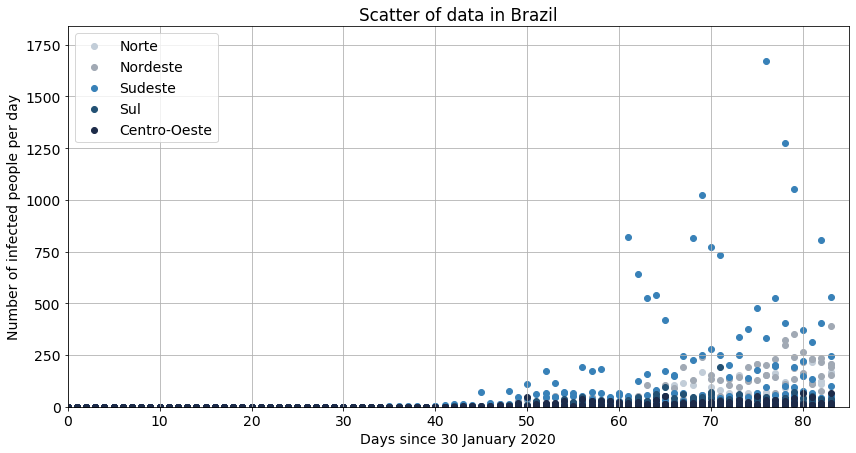

In [55]:
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

dfs = dfs.sort_values("data")
y = list(dfs.iloc[:, 3])

# Real data
# Brazilian areas separated

plt.scatter(list(dfs[dfs['regiao'] == 'Norte'].iloc[:, 1]), list(dfs[dfs['regiao'] == 'Norte'].iloc[:, 3]), 
            label = "Norte", color = "#c2cdd8")
plt.scatter(list(dfs[dfs['regiao'] == 'Nordeste'].iloc[:, 1]), list(dfs[dfs['regiao'] == 'Nordeste'].iloc[:, 3]), 
            label = "Nordeste", color = "#a1a9b4")
plt.scatter(list(dfs[dfs['regiao'] == 'Sudeste'].iloc[:, 1]), list(dfs[dfs['regiao'] == 'Sudeste'].iloc[:, 3]), 
            label = "Sudeste", color = "#3881b8")
plt.scatter(list(dfs[dfs['regiao'] == 'Sul'].iloc[:, 1]), list(dfs[dfs['regiao'] == 'Sul'].iloc[:, 3]), 
            label = 'Sul', color = '#235174')
plt.scatter(list(dfs[dfs['regiao'] == 'Centro-Oeste'].iloc[:, 1]), list(dfs[dfs['regiao'] == 'Centro-Oeste'].iloc[:, 3]), 
            label = 'Centro-Oeste', color = "#1d2b49")

plt.grid(True)
plt.title("Scatter of data in Brazil")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Number of infected people per day")
plt.xlim(0, max(x) + 2)
plt.ylim(0, max(y) * 1.1)
plt.show()

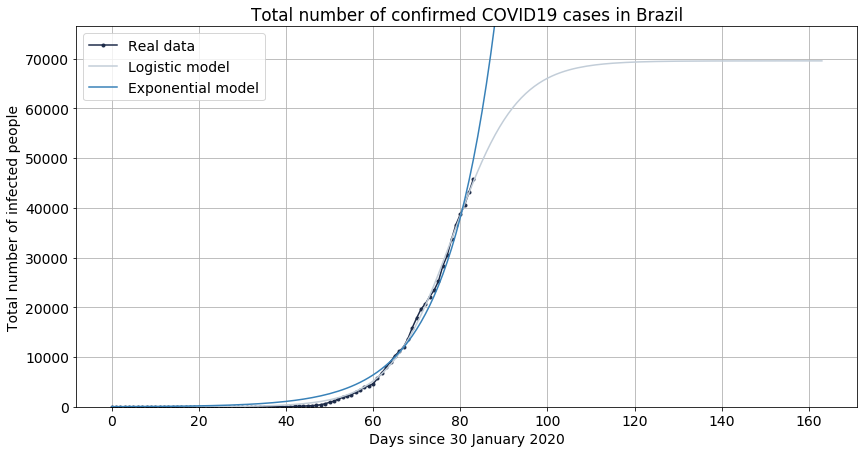

In [37]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

pred_x = list(range(max(x), logistic_sol))
y = list(df1.iloc[:, 0])

# Real data
plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

# Predicted logistic curve
plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0], logistic_fit[0][1], logistic_fit[0][2]) 
                      for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                      for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Total number of confirmed COVID19 cases in Brazil")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Total number of infected people")
plt.ylim(0, logistic_fit[0][2] * 1.1)
plt.show()

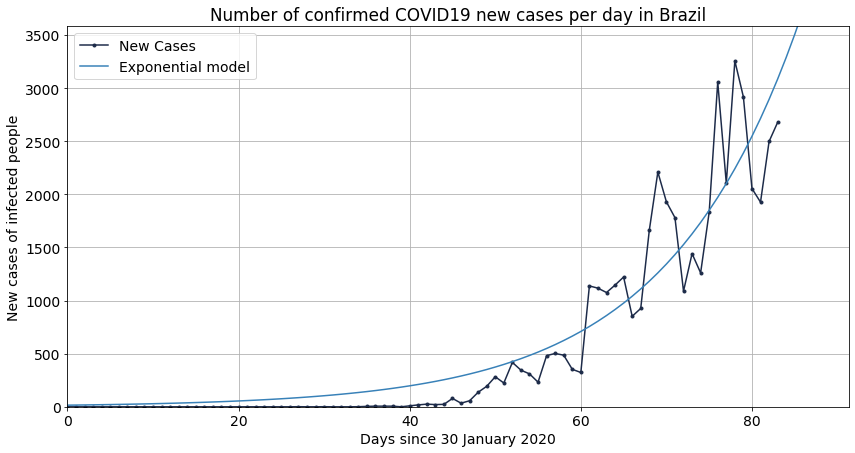

In [38]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

pred_x = list(range(max(x), new_logistic_sol))
y = list(df1.iloc[:, 1])

plt.plot(x, y, marker = '.', label = "New Cases", color="#1d2b49")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, new_exponential_fit[0][0], new_exponential_fit[0][1], new_exponential_fit[0][2])
                    for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Number of confirmed COVID19 new cases per day in Brazil")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("New cases of infected people")
plt.ylim(0, max(y) * 1.1)
plt.xlim(0, max(x) * 1.1)
plt.show()

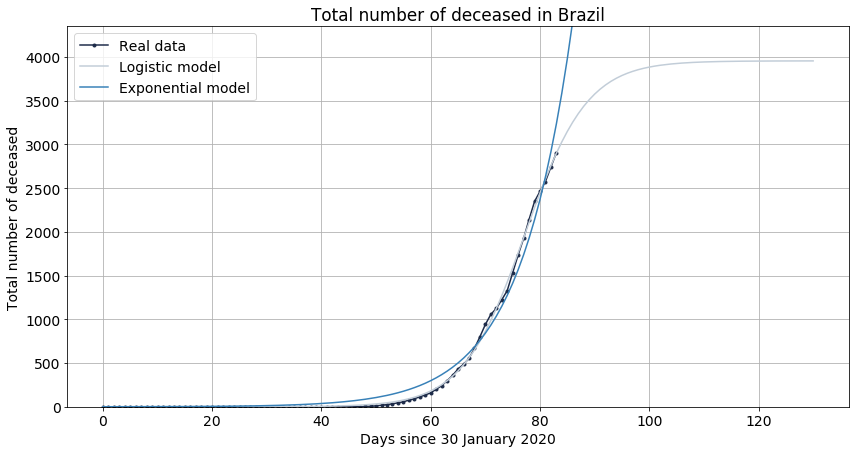

In [39]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

pred_x = list(range(max(x), death_logistic_sol))
y = list(df1.iloc[:, 2])

# Real data
plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

# Predicted logistic curve
plt.plot(x + pred_x, [logistic_model(i, death_logistic_fit[0][0], death_logistic_fit[0][1], death_logistic_fit[0][2])
                      for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, death_exponential_fit[0][0], death_exponential_fit[0][1], death_exponential_fit[0][2])
                      for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Total number of deceased in Brazil")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Total number of deceased")
plt.ylim(0, death_logistic_fit[0][2] * 1.1)
plt.show()

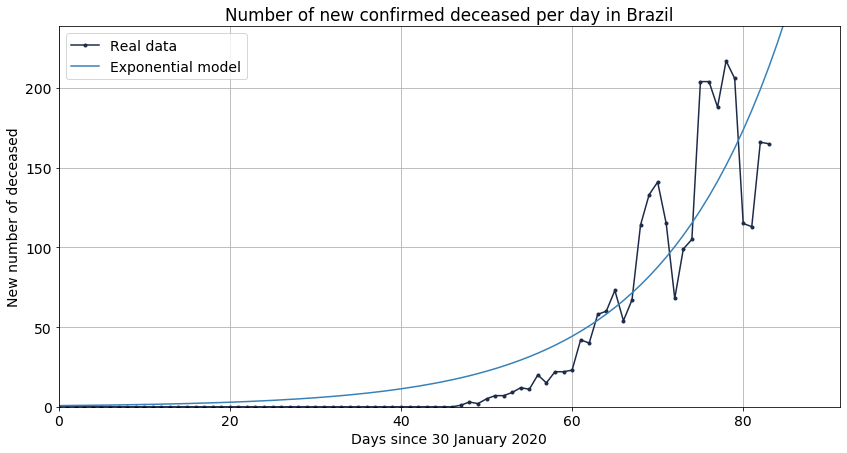

In [40]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

pred_x = list(range(max(x), death_logistic_sol))
y = list(df1.iloc[:, 3])

# Real data
plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, new_death_exponential_fit[0][0], new_death_exponential_fit[0][1], new_death_exponential_fit[0][2])
                      for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Number of new confirmed deceased per day in Brazil")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("New number of deceased")
plt.xlim(0, max(x) * 1.1)
plt.ylim(0, max(y) * 1.1)
plt.show()

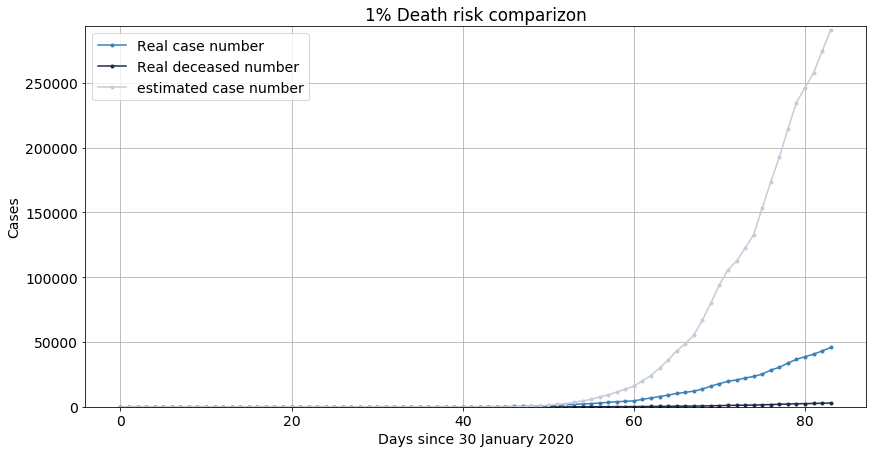

In [43]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

# Real data

y = list(df1.iloc[:, 0])
plt.plot(x, y, marker = '.', label = "Real case number", color = "#3881b8")

y = list(df1.iloc[:, 2])

plt.plot(x, y, marker = '.', label = "Real deceased number", color = "#1d2b49")

y = list(df1.iloc[:, 2].multiply(100))

plt.plot(x, y, marker = '.', label = "estimated case number", color = "#c2cdd8")

plt.title("1% Death risk comparizon")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Cases")
plt.ylim(0, max(y) * 1.01)
plt.show()

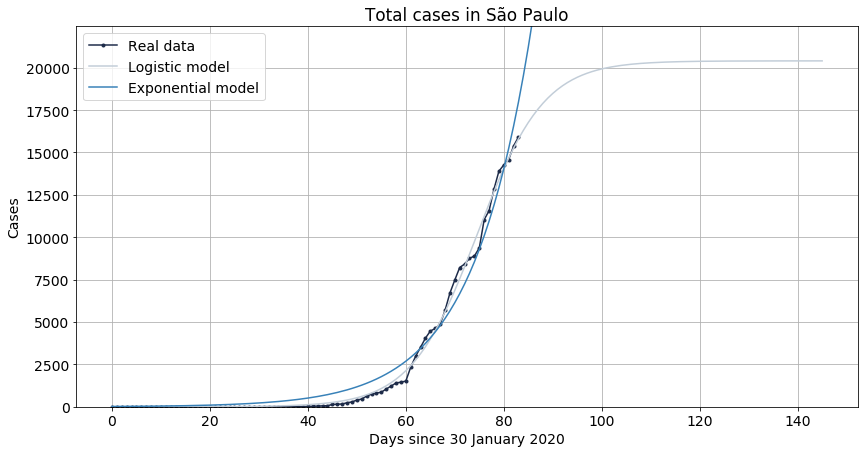

In [44]:
df_SP = df_UF.loc[df_UF.iloc[:,0] == 'SP', :].iloc[:, [1, 2]]

y = list(df_SP.iloc[:, 1])

plt.grid(True)

# Real data
plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df.index.size))
exponential_sol = int(fsolve(lambda x : exponential_model(x, exponential_fit[0][0], exponential_fit[0][1], 
                                                          exponential_fit[0][2]) - int(exponential_fit[0][2]), exponential_fit[0][1]))

logistic_fit = curve_fit(logistic_model, x, y, p0 = [2, 100, 20000])
logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1], 
                                                    logistic_fit[0][2]) - int(logistic_fit[0][2]), logistic_fit[0][1]))

pred_x = list(range(max(x), logistic_sol))

# Predicted logistic curve
plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0], logistic_fit[0][1], logistic_fit[0][2])
                      for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                      for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Total cases in São Paulo")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Cases")
plt.ylim(0, logistic_fit[0][2] * 1.1)
plt.show()

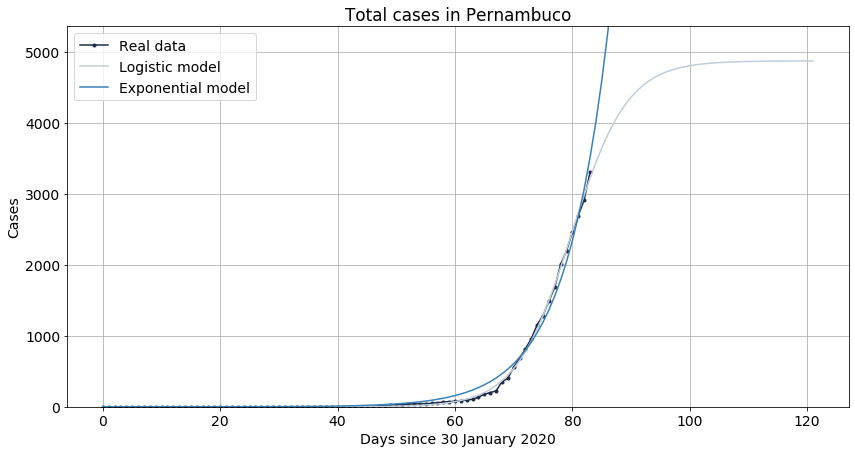

In [45]:
df_PE = df_UF.loc[df_UF.iloc[:,0] == 'PE', :].iloc[:, [1, 2]]

y = list(df_PE.iloc[:, 1])

plt.grid(True)

# Real data
plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df.index.size))
exponential_sol = int(fsolve(lambda x : exponential_model(x, exponential_fit[0][0], exponential_fit[0][1], 
                                                          exponential_fit[0][2]) - int(exponential_fit[0][2]), exponential_fit[0][1]))

logistic_fit = curve_fit(logistic_model, x, y, p0 = [2, 100, 20000])
logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1], 
                                                    logistic_fit[0][2]) - int(logistic_fit[0][2]), logistic_fit[0][1]))

pred_x = list(range(max(x), logistic_sol))

# Predicted logistic curve
plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0], logistic_fit[0][1], logistic_fit[0][2])
                      for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                      for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Total cases in Pernambuco")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Cases")
plt.ylim(0, logistic_fit[0][2] * 1.1)
plt.show()

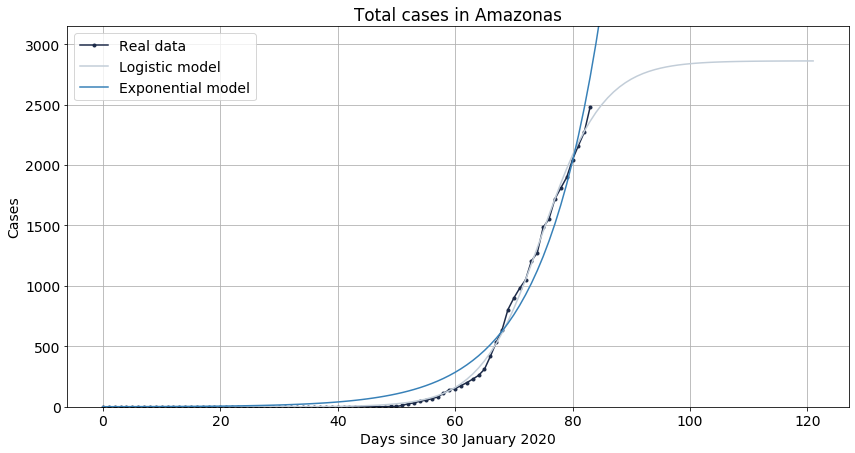

In [46]:
df_AM = df_UF.loc[df_UF.iloc[:,0] == 'AM', :].iloc[:, [1, 2]]

y = list(df_AM.iloc[:, 1])

plt.grid(True)

# Real data
plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df.index.size))
exponential_sol = int(fsolve(lambda x : exponential_model(x, exponential_fit[0][0], exponential_fit[0][1], 
                                                          exponential_fit[0][2]) - int(exponential_fit[0][2]), exponential_fit[0][1]))

logistic_fit = curve_fit(logistic_model, x, y, p0 = [2, 100, 20000])
logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1], 
                                                    logistic_fit[0][2]) - int(logistic_fit[0][2]), logistic_fit[0][1]))

pred_x = list(range(max(x), logistic_sol))

# Predicted logistic curve
plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0], logistic_fit[0][1], logistic_fit[0][2])
                      for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                      for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Total cases in Amazonas")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Cases")
plt.ylim(0, logistic_fit[0][2] * 1.1)
plt.show()